# Heurística para escolher o melhor valor de cada característica
### Usando a Entropia ao invés da Impureza Gini

In [1]:
# Importando o dataset da Iris

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def entropia(y):
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i, k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    resultado = sum(-probabilidades*np.log10(probabilidades)) # Fiz o cálculo da entropia aqui
    return resultado

def entropiaValor(x, y, valor): #função custo que o algoritmo tenta minimizar
    maiores = x>valor
    entropiaMaiores = entropia(y[maiores])
    propMaiores = sum(maiores)/len(y)
    entropiaMenores = entropia(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    entropiaTotal = propMaiores*entropiaMaiores + propMenores*entropiaMenores
    return entropiaTotal, entropiaMaiores, entropiaMenores

In [36]:
ytmp = y[:]
valor = entropia(ytmp)
valor

0.4771212547196624

In [37]:
entropiaValor(X[:,0], y, 2.5)

(0.20068666377598746, 0.3010299956639812, 0.0)

In [38]:
# Criar uma heurística para encontrar o melhor valor para cada característica

def melhorValor(x, y):
    result = None
    menorEntropia = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        entTotal, entMaiores, entMenores = entropiaValor(x, y, valor)
        if entTotal < menorEntropia:
            menorEntropia = entTotal
            result = valor
            if entMaiores == 0 or entMenores == 0:
                break
            if entMaiores < entMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorEntropia

In [39]:
melhorValor(X[:,0], y)

(2.475, 0.20068666377598746)

In [40]:
# A partir dos valores da menor característica, encontrar a menor característica

def melhorCaracteristica(X, y):
    entropia = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, ent = melhorValor(X[:, caracteristica], y)
        entropia.append(ent)
        valores.append(valor)
    entropia = np.array(entropia)
    caracteristica = np.argmin(entropia)
    return caracteristica, valores[caracteristica], entropia[caracteristica]

In [41]:
print(melhorCaracteristica(X,y))

(0, 2.475, 0.20068666377598746)


In [42]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.ent = melhorCaracteristica(X, y)
        maiores = X[:, self.caracteristica] > self.valor
        if sum(maiores) > 0 and sum(~maiores) > 0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

In [43]:
def plotDecisao(modelo, X, y):
        
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")

    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

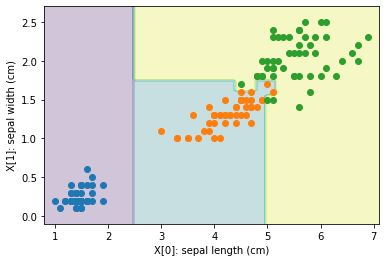

In [44]:
plotDecisao(Arvore(), X, y)

In [45]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

# Comparando com o resultado obtido em aula

In [46]:
def impureza(y): # Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i, k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    resultado = 1 - sum(probabilidades**2) # resultados acima de 0 indicam algum grau de impureza
    return resultado

def impurezaValor(x, y, valor): #função custo que o algoritmo tenta minimizar
    maiores = x>valor
    impurezasMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezasMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezasMaiores + propMenores*impurezasMenores
    return impurezaTotal, impurezasMaiores, impurezasMenores

def melhorValor_imp(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica_imp(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_imp(X[:, caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


class Arvore_aula(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_imp(X, y)
        maiores = X[:, self.caracteristica] > self.valor
        if sum(maiores) > 0 and sum(~maiores) > 0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

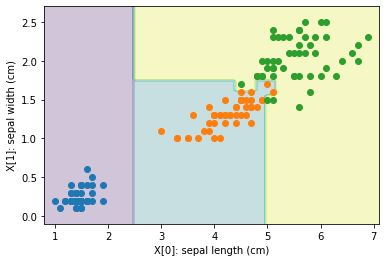

In [49]:
plotDecisao(Arvore_aula(), X, y)

# Comparando com o a implementação da Árvore de Decisão do scikit learn

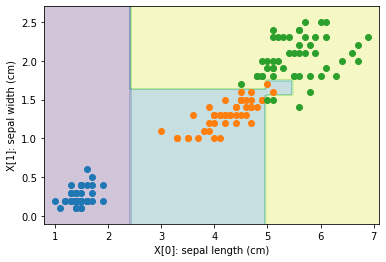

In [50]:
from sklearn.tree import DecisionTreeClassifier
plotDecisao(DecisionTreeClassifier(), X, y)

# Comparação usando validação cruzada com 3 bases de classificação com atributos contínuos

### Dataset Haberman's Survival

In [58]:
import urllib.request
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
urllib.request.urlretrieve(url, 'haberman.data')

('haberman.data', <http.client.HTTPMessage at 0x1cf36350100>)

In [63]:
data_haberman = np.loadtxt('haberman.data', dtype='str', delimiter=',')
X_1, y_1 = data_haberman[:,:-1], data_haberman[:, -1]
X_1.shape, y_1.shape

((306, 3), (306,))

In [96]:
X_1 = X_1.astype(int)
y_1 = y_1.astype(int)

In [97]:
scores = cross_validate(Arvore(), X_1, y_1)
scores['test_score'], np.mean(scores['test_score'])

(array([0.72580645, 0.49180328, 0.62295082, 0.63934426, 0.55737705]),
 0.6074563722897939)

In [128]:
scores_aula = cross_validate(Arvore_aula(), X_1, y_1)
scores_aula['test_score'], np.mean(scores_aula['test_score'])

(array([0.72580645, 0.49180328, 0.62295082, 0.63934426, 0.55737705]),
 0.6074563722897939)

In [131]:
scores_sklearn = cross_validate(DecisionTreeClassifier(max_depth=3), X_1, y_1)
scores_sklearn['test_score'], np.mean(scores_sklearn['test_score'])

(array([0.72580645, 0.67213115, 0.73770492, 0.72131148, 0.72131148]),
 0.7156530936012692)

### Dataset Exasens

In [116]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00523/Exasens.csv'
urllib.request.urlretrieve(url, 'exasens.csv')

('exasens.csv', <http.client.HTTPMessage at 0x1cf362f7e50>)

In [117]:
import pandas as pd
df = pd.read_csv('exasens.csv')

In [118]:
df.head(10)

,Diagnosis,ID,Imaginary Part,Unnamed: 3,Real Part,Unnamed: 5,Gender,Age,Smoking,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Min,Avg.,Min,Avg.,NaN,NaN,NaN,NaN,NaN,Gender,Somking
2,COPD,301-4,-320.61,-300.5635307,-495.26,-464.1719907,1.0,77.0,2.0,NaN,NaN,Male=1,Non-smoker=1
3,COPD,302-3,-325.39,-314.7503595,-473.73,-469.2631404,0.0,72.0,2.0,NaN,NaN,Female=0,Ex-smoker=2
4,COPD,303-3,-323,-317.4360556,-476.12,-471.8976667,1.0,73.0,3.0,NaN,NaN,NaN,Active-smoker=3
5,COPD,304-4,-327.78,-317.3996698,-473.73,-468.856388,1.0,76.0,2.0,NaN,NaN,NaN,NaN
6,COPD,305-4,-325.39,-316.1557853,-478.52,-472.8697828,0.0,65.0,2.0,NaN,NaN,NaN,NaN
7,COPD,306-3,-327.78,-318.6775535,-507.23,-469.0241943,1.0,60.0,2.0,NaN,NaN,NaN,NaN
8,COPD,307-3,-330.18,-320.6174777,-473.73,-467.3618538,1.0,76.0,2.0,NaN,NaN,NaN,NaN
9,COPD,308,NaN,NaN,NaN,NaN,1.0,77.0,2.0,NaN,NaN,NaN,NaN


In [119]:
df.dropna(subset=['Diagnosis', 'Real Part'], inplace=True) # dando drop nas linhas faltantes

In [120]:
df.head()

,Diagnosis,ID,Imaginary Part,Unnamed: 3,Real Part,Unnamed: 5,Gender,Age,Smoking,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
2,COPD,301-4,-320.61,-300.5635307,-495.26,-464.1719907,1.0,77.0,2.0,NaN,NaN,Male=1,Non-smoker=1
3,COPD,302-3,-325.39,-314.7503595,-473.73,-469.2631404,0.0,72.0,2.0,NaN,NaN,Female=0,Ex-smoker=2
4,COPD,303-3,-323,-317.4360556,-476.12,-471.8976667,1.0,73.0,3.0,NaN,NaN,NaN,Active-smoker=3
5,COPD,304-4,-327.78,-317.3996698,-473.73,-468.856388,1.0,76.0,2.0,NaN,NaN,NaN,NaN
6,COPD,305-4,-325.39,-316.1557853,-478.52,-472.8697828,0.0,65.0,2.0,NaN,NaN,NaN,NaN


In [ ]:
df.Diagnosis = df.Diagnosis.astype('category')
df['categorias'] = df.Diagnosis.cat.codes
df.head()

In [123]:
X_2 = df[['Imaginary Part', 'Unnamed: 3', 'Real Part', 'Unnamed: 5', 'Gender', 'Age', 'Smoking']]
y_2 = df.categorias

X_2 = np.array(X_2).astype(float)
y_2 = np.array(y_2).astype(int)

In [124]:
X_2.shape, y_2.shape

((100, 7), (100,))

In [132]:
scores2 = cross_validate(Arvore(), X_2, y_2)
scores2['test_score'], np.mean(scores2['test_score'])

(array([0.5 , 0.75, 0.7 , 0.55, 0.75]), 0.65)

In [133]:
scores_aula2 = cross_validate(Arvore_aula(), X_2, y_2)
scores_aula2['test_score'], np.mean(scores_aula2['test_score'])

(array([0.5 , 0.7 , 0.7 , 0.55, 0.75]), 0.64)

In [134]:
scores_sklearn2 = cross_validate(DecisionTreeClassifier(), X_2, y_2)
scores_sklearn2['test_score'], np.mean(scores_sklearn2['test_score'])

(array([0.45, 0.6 , 0.85, 0.7 , 0.8 ]), 0.6799999999999999)

### Blood Transfusion Service Center Data Set

In [135]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data'
urllib.request.urlretrieve(url, 'blood_transfusion.data')

('blood_transfusion.data', <http.client.HTTPMessage at 0x1cf36350d30>)

In [141]:
data_blood_transfusion = np.loadtxt('blood_transfusion.data', dtype='str', delimiter=',', skiprows=1)
X_3, y_3 = data_blood_transfusion[:,:-1], data_blood_transfusion[:, -1]
X_3.shape, y_3.shape

((748, 4), (748,))

In [145]:
X_3 = X_3.astype(int)
y_3 = y_3.astype(int)

In [146]:
scores3 = cross_validate(Arvore(), X_3, y_3)
scores3['test_score'], np.mean(scores3['test_score'])

(array([0.47333333, 0.63333333, 0.66666667, 0.75167785, 0.73154362]),
 0.6513109619686801)

In [147]:
scores_aula3 = cross_validate(Arvore_aula(), X_3, y_3)
scores_aula3['test_score'], np.mean(scores_aula3['test_score'])

(array([0.48      , 0.63333333, 0.66666667, 0.75167785, 0.73154362]),
 0.6526442953020134)

In [149]:
scores_sklearn3 = cross_validate(DecisionTreeClassifier(max_depth=3), X_3, y_3)
scores_sklearn3['test_score'], np.mean(scores_sklearn3['test_score'])

(array([0.68      , 0.84666667, 0.78666667, 0.74496644, 0.81208054]),
 0.7740760626398211)

Neste exercício, fiz a heurística de escolha para a melhor característica utilizando a entropia como medida de impureza. Na aula, o professor utilizou a impureza Gini. Elas são calculadas de maneira diferente, mas em geral apresentam resultados bem próximos. De fato, Na comparação dos plots das regiões de decisão usando a base iris, ambos ficaram iguais. A diferença surgiu quando foi feita a avaliação das outras 3 bases de classificação com atributos contínuos, mas mesmo assim a diferença não foi tão grande e os scores obtidos pelas duas heurísticas ficaram bem próximos.

No caso da comparação com a implementação disponível no scikit learn, a diferença ficou mais evidente. Primeiro, o plot obtido pelo modelo do scikit apresentou regiões diferentes dos outros dois modelos. Além disso, os scores obtidos nas bases testadas foram maiores para o modelo do scikit learn.